In [64]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

device = torch.device("cpu")


In [65]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [66]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence, is_cn=False):
        for word in (sentence.split(' ') if not is_cn else list(sentence)):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    def sentenceToIndexes(self, sentence):
        words = [word for word in sentence.split('')]
        indexes = [0, ]



In [67]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s, is_cn = False):
    
    if (is_cn):
        s = s.strip()
        s = re.sub(r"([。！？])", r" \1", s)
    else:
        s = unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [68]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s, i == 1 if reverse else i == 0) for i, s in enumerate(l.split('\t'))] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


In [69]:
MAX_LENGTH = 15

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(list(p[0])) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [70]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0], True)
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('en', 'cn', True)
print(random.choice(pairs))


Reading lines...
Read 29371 sentence pairs
Trimmed to 2160 sentence pairs
Counting words...
Counted words:
cn 1209
en 1431
['她钱不够 。', 'she is hard up for money .']


In [71]:
def indexesFromSentence(lang, sentence, is_cn=False):
    return [lang.word2index[word] for word in (sentence.split(' ') if not is_cn else list(sentence))]

def tensorFromSentence(lang, sentence, is_cn=False):
    indexes = indexesFromSentence(lang, sentence, is_cn)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0], True)
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [72]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [74]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.GRU(hidden_size + hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size + hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden, context):
        embedded = self.dropout(self.embedding(input)).view(1, 1, -1)

        emb_con = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim = 1)
        output = self.softmax(self.out(output))
        return output, hidden

In [75]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    decoder_input = torch.tensor([[SOS_token]], device=device)

    context = encoder_hidden
    decoder_hidden = encoder_hidden #

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [76]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [82]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, True)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()


        encoder_output, encoder_hidden = encoder(input_tensor,encoder_hidden)
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        context = encoder_hidden
        decoder_hidden = encoder_hidden

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


In [83]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [79]:
hidden_size = 256
encoder1 = Encoder(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

train_losses = trainIters(encoder1, decoder1, 75000, print_every=5000)


1m 56s (- 27m 8s) (5000 6%) 3.1737
3m 54s (- 25m 25s) (10000 13%) 1.9892
5m 54s (- 23m 39s) (15000 20%) 1.2858
7m 56s (- 21m 50s) (20000 26%) 0.8727
9m 58s (- 19m 57s) (25000 33%) 0.5716
12m 1s (- 18m 2s) (30000 40%) 0.4417
14m 4s (- 16m 5s) (35000 46%) 0.3453
16m 8s (- 14m 7s) (40000 53%) 0.3032
18m 13s (- 12m 9s) (45000 60%) 0.2545
22m 4s (- 11m 2s) (50000 66%) 0.2387
24m 9s (- 8m 47s) (55000 73%) 0.2282
26m 15s (- 6m 33s) (60000 80%) 0.2260
28m 25s (- 4m 22s) (65000 86%) 0.2400
30m 34s (- 2m 11s) (70000 93%) 0.2172
32m 44s (- 0m 0s) (75000 100%) 0.2185


<Figure size 640x480 with 0 Axes>

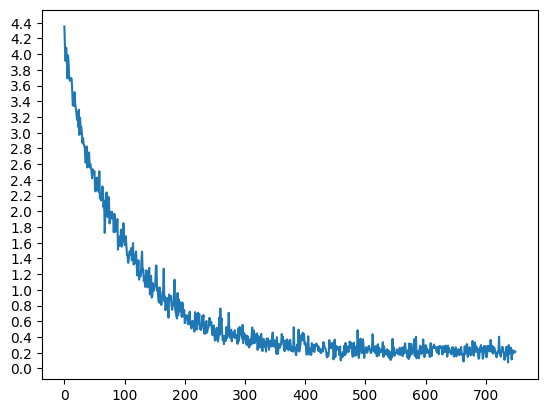

In [80]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

showPlot(train_losses)

In [85]:
encoder_path = './models/seq2seq3-encoder.pt'
decoder_path = './models/seq2seq3-decoder.pt'

In [86]:
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)

In [93]:
hidden_size = 256
encoder = Encoder(input_lang.n_words, hidden_size).to(device)
decoder = Decoder(hidden_size, output_lang.n_words).to(device)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

<All keys matched successfully>

In [95]:
evaluateRandomly(encoder, decoder)

> 我对你的大胆感到很惊讶 。
= i am amazed at your audacity .
< i am amazed at your audacity . <EOS>

> 我去弄饮料给你 。
= i m going to make you a drink .
< i m going to make you a drink . <EOS>

> 我什么都不怕 。
= i m not afraid of anything .
< i m not afraid of anything . <EOS>

> 我现在正在读一本书 。
= i am reading a book now .
< i am reading a book now . <EOS>

> 你现在是大人了 。
= you are now an adult .
< you are now an adult . <EOS>

> 我是据我所知最懒的人 。
= i am the laziest person i know .
< i am the laziest person i know . <EOS>

> 今天我要去看他 。
= i am going to see him today .
< i am going to see him today . <EOS>

> 你说得很对 。
= you are quite right .
< you are quite right . <EOS>

> 我反对任何形式的战争 。
= i m opposed to any type of war .
< i m opposed to any type of war . <EOS>

> 你够大了知道不要那样做 。
= you are old enough to know better than to act like that .
< you are old enough to know better than to act like . <EOS>



In [98]:
output_words = evaluate(encoder, decoder, '我是快乐的')
output_sentence = ' '.join(output_words)
print(output_sentence)

i m innocent . <EOS>
